# Tutorial 1: Integrating adjacent DLPFC slices
This tutorial demonstrates STAligner's ablility to integrate multiple adjacent slices. The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://drive.google.com/drive/folders/1pHJy2cB9BKqc3ny9IpvVhiw_8ukJMzPW?usp=share_link.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
Batch_list = []
adj_list = []
section_ids = ['151669','151670','151671','151672']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('../../../data/DLPFC', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, 'manual_annotations.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')
    
    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    
    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
    
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151669', '151670', '151671', '151672']
151669
------Calculating spatial graph...
The graph contains 21194 edges, 3661 cells.
5.7891 neighbors per cell on average.
151670
------Calculating spatial graph...
The graph contains 20370 edges, 3498 cells.
5.8233 neighbors per cell on average.
151671
------Calculating spatial graph...
The graph contains 24052 edges, 4110 cells.
5.8521 neighbors per cell on average.
151672
------Calculating spatial graph...
The graph contains 23382 edges, 4015 cells.
5.8237 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (15284, 946)


## Concat the spatial network for multiple slices

In [5]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [6]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

STAligner(
  (conv1): GATConv(946, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 946, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:05<00:00, 85.20it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|█▉        | 99/500 [00:06<00:05, 68.81it/s]

Update spot triplets at epoch 600


 39%|███▉      | 195/500 [00:12<00:05, 59.91it/s]

Update spot triplets at epoch 700


 59%|█████▉    | 296/500 [00:18<00:03, 61.79it/s]

Update spot triplets at epoch 800


 80%|████████  | 400/500 [00:24<00:01, 64.52it/s]

Update spot triplets at epoch 900


100%|██████████| 500/500 [00:30<00:00, 16.17it/s]

CPU times: total: 2min 32s
Wall time: 37.1 s


## Clustering

In [7]:
STAligner.ST_utils.mclust_R(adata_concat, num_cluster=5, used_obsm='STAligner')
adata_concat = adata_concat[adata_concat.obs['Ground Truth']!='unknown']

from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
mclust, ARI = 0.465


In [8]:
for name in section_ids:
    sub_adata_tmp = adata_concat[adata_concat.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

151669 ARI:0.44364240821070877
151670 ARI:0.43679011690924197
151671 ARI:0.5292169047029904
151672 ARI:0.550471652618443


In [9]:
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score
from my6_Triplet.utils import compute_PAS, compute_CHAOS

print('mclust, Total NMI = %01.3f' % nmi_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
print('mclust, Total AMI = %01.3f' % ami_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
for name in section_ids:
    sub_adata_tmp = adata_concat[adata_concat.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    AMI = ami_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} Acc:{ACC}")

mclust, Total NMI = 0.589
mclust, Total AMI = 0.589
151669 Acc:0.584643062886143
151670 Acc:0.5513003948605579
151671 Acc:0.6452633937596117
151672 Acc:0.6570936472761537


In [10]:
print('mclust, Total HOM = %01.3f' % hom_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
print('mclust, Total COM = %01.3f' % hom_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
for name in section_ids:
    sub_adata_tmp = adata_concat[adata_concat.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    COM = com_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    V = 2*(HOM*COM)/(HOM+COM)
    print(f"{name} V:{V}")

mclust, Total HOM = 0.630
mclust, Total COM = 0.630
151669 V:0.5849846629257929
151670 V:0.5517013330409046
151671 V:0.6455010736784165
151672 V:0.6573314592695553


2.2558444401246356
1.0605554808363242


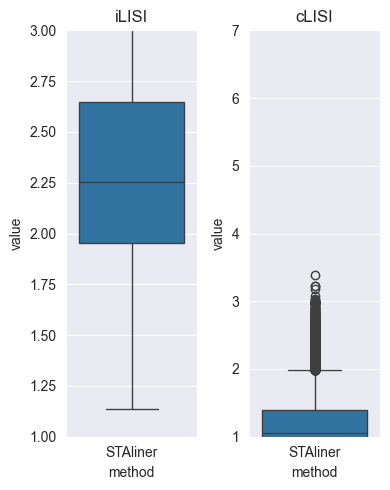

In [11]:
import seaborn as sns
import harmonypy as hm
import matplotlib.pyplot as plt

iLISI = hm.compute_lisi(adata_concat.obsm['STAligner'], adata_concat.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata_concat.obsm['STAligner'], adata_concat.obs[['Ground Truth']], label_colnames=['Ground Truth'])[:, 0]

df_iLISI = pd.DataFrame({
    'method': 'STAliner',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'STAliner',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

## Visualization

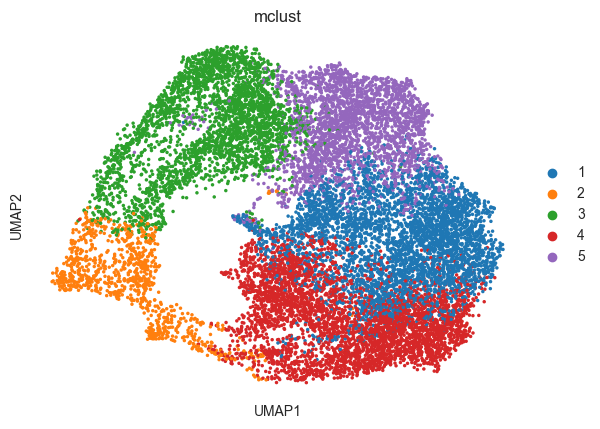

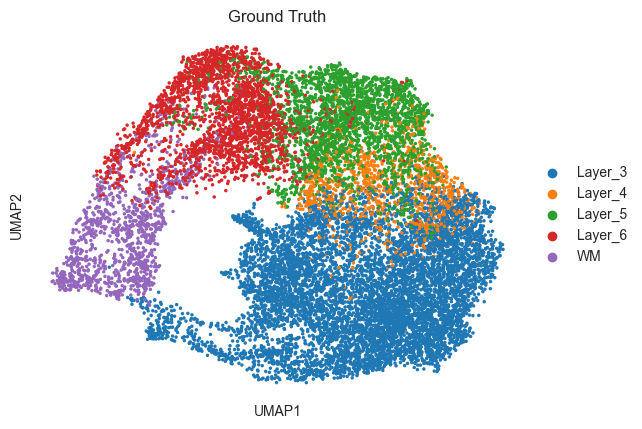

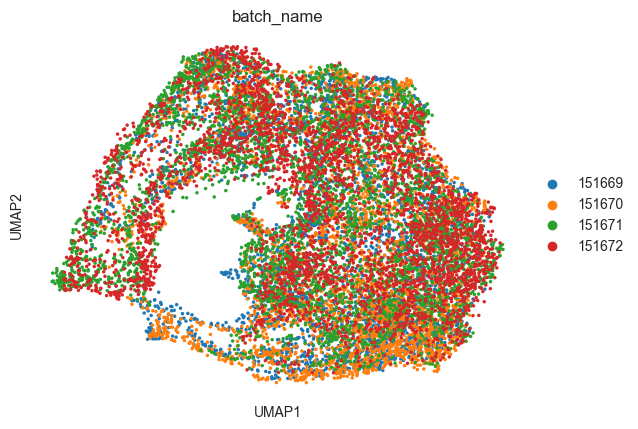

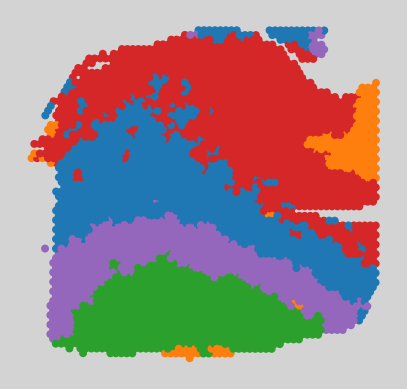

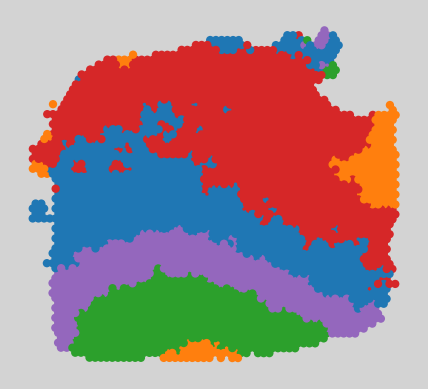

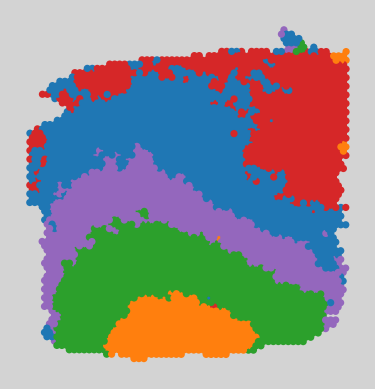

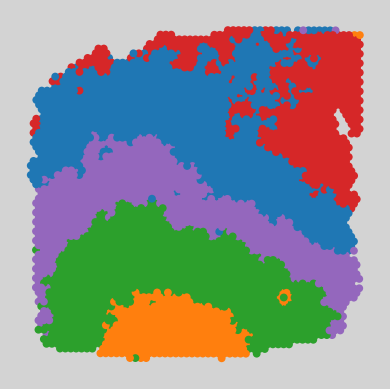

In [13]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

sc.pl.umap(adata_concat, color=['mclust'], show=True, size=25, save=False)
sc.pl.umap(adata_concat, color=['Ground Truth'], show=True, size=25, save=False)
sc.pl.umap(adata_concat, color=['batch_name'], show=True, size=25, save=False)

plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

for section_id in section_ids:
    adata_tmp = adata_concat[adata_concat.obs['batch_name'] == section_id]
    sc.pl.spatial(adata_tmp, img_key=None, color=['mclust'], title=[''],
                  legend_fontsize=12, show=False, frameon=False, legend_loc=None,
                  spot_size=200)

    plt.savefig('STAlinear_' + section_id + '.png', dpi=300, bbox_inches='tight')

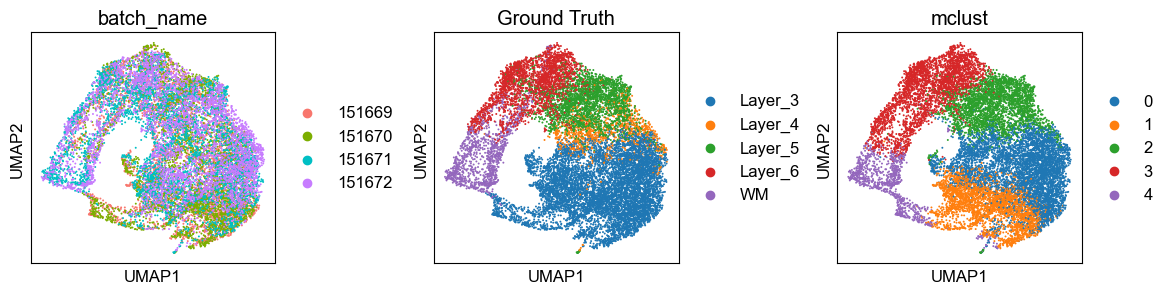

In [19]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
adata_concat.obs['mclust'] = pd.Series(STAligner.ST_utils.match_cluster_labels(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3, 
           wspace=0.5, show=True)

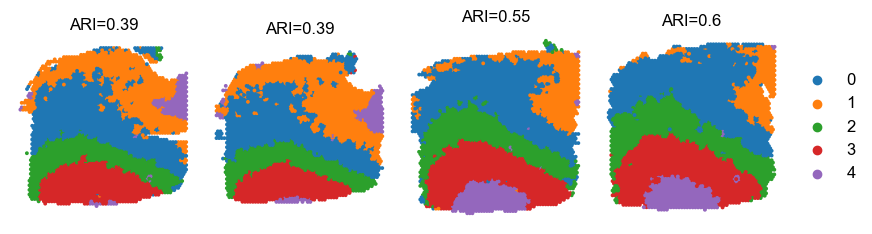

In [20]:
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()